## 転移学習と微調整
まず、保存されているモデルを読み込みます。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
model=tf.keras.models.load_model('/content/drive/MyDrive/my_fashion_mnist_model.h5')

Mounted at /content/drive


データを読み込み、正規化します。

In [ ]:
mnist = tf.keras.datasets.mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images  = training_images / 255.0
test_images = test_images / 255.0

11490434/11490434 [==============================] - 2s 0us/step


最終的な検証用の損失と精度を数値で確認しておきます。

In [ ]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 4s 7ms/step - loss: 9.5528 - accuracy: 0.1057


[9.552846908569336, 0.10570000112056732]

## 別のデータセットへの転用
別のデータセットを読み込みます。データ件数が少ない場合を試したいので、それぞれ件数を1/10に減らして訓練してみましょう。

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = fashion_mnist.load_data()

(train_size, test_size) = (len(training_images), len(test_images))
(training_images, training_labels) = (training_images[:train_size//10], training_labels[:train_size//10])
(test_images, test_labels) = (test_images[:test_size//10], test_labels[:test_size//10])

training_images  = training_images / 255.0
test_images = test_images / 255.0
print(len(training_images), len(test_images))

4422102/4422102 [==============================] - 1s 0us/step
6000 1000


新しいデータセットには元のモデルは全く性能が出ないことを確認しておきます。

In [ ]:
model.evaluate(test_images, test_labels)

32/32 [==============================] - 0s 7ms/step - loss: 0.2495 - accuracy: 0.9200


[0.2494526207447052, 0.9200000166893005]

転移学習を行います。最終層以外を凍結します。

In [ ]:
for layer in model.layers[:-1]:
    layer.trainable=False
model.layers[-1].trainable=True

モデルを確認すると、Trainable paramsが少ないことから、多くの層が凍結されていることが確認できます。

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dropout (Dropout)           (None, 800)               0

コンパイルし、転移学習してみます。1階層しか重みを変更しないため、1エポックあたりの計算時間は短縮されているはずです。

In [ ]:
import time

start = time.time()

model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
train_hist=model.fit(training_images, training_labels, epochs=20, verbose=1,
                     validation_data=(test_images, test_labels), batch_size=128)

print(time.time() - start)

Epoch 1/20
47/47 [==============================] - 3s 12ms/step - loss: 0.2152 - accuracy: 0.9197 - val_loss: 0.2484 - val_accuracy: 0.9180
Epoch 2/20
47/47 [==============================] - 0s 4ms/step - loss: 0.2046 - accuracy: 0.9272 - val_loss: 0.2464 - val_accuracy: 0.9170
Epoch 3/20
47/47 [==============================] - 0s 4ms/step - loss: 0.2072 - accuracy: 0.9233 - val_loss: 0.2454 - val_accuracy: 0.9200
Epoch 4/20
47/47 [==============================] - 0s 4ms/step - loss: 0.2038 - accuracy: 0.9237 - val_loss: 0.2467 - val_accuracy: 0.9200
Epoch 5/20
47/47 [==============================] - 0s 4ms/step - loss: 0.1985 - accuracy: 0.9248 - val_loss: 0.2454 - val_accuracy: 0.9180
Epoch 6/20
47/47 [==============================] - 0s 5ms/step - loss: 0.2018 - accuracy: 0.9255 - val_loss: 0.2459 - val_accuracy: 0.9180
Epoch 7/20
47/47 [==============================] - 0s 6ms/step - loss: 0.1944 - accuracy: 0.9262 - val_loss: 0.2463 - val_accuracy: 0.9210
Epoch 8/20
47/47 [=

データ件数が少ないものの、それなりに収束はしますが、性能がそれほど良くないことが確認できます。

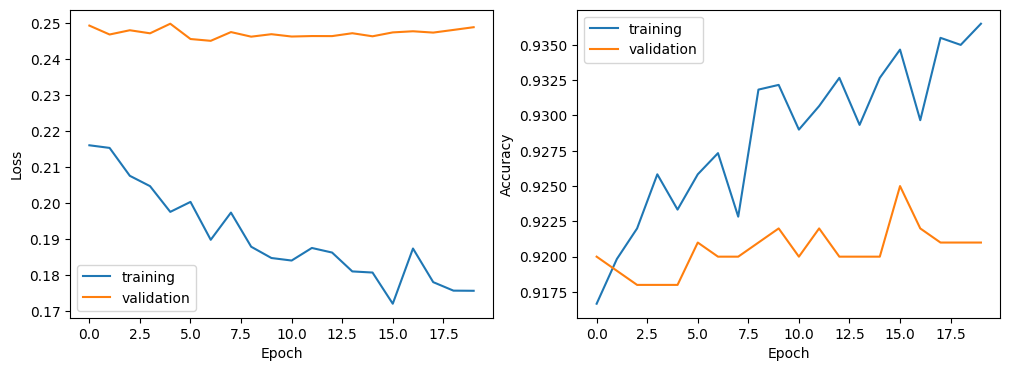

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
figs, axs=plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(train_hist.history['loss'], label='training')
axs[0].plot(train_hist.history['val_loss'], label='validation')
axs[0].legend()
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[1].plot(train_hist.history['accuracy'], label='training')
axs[1].plot(train_hist.history['val_accuracy'], label='validation')
axs[1].legend()
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
plt.show()

さらに微調整してみます。ここでは全層を解凍し、学習率を1e-5に設定して20エポックほど訓練してみましょう。

In [ ]:
start = time.time()

for layer in model.layers:
    layer.trainable=True

sec1 = time.time()

model.compile(optimizer = tf.optimizers.Adam(1e-5),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

sec2 = time.time()

train_hist=model.fit(training_images, training_labels, epochs=20, verbose=1,
                     validation_data=(test_images, test_labels), batch_size=128)

sec3 = time.time()
print(sec1 - start)
print(sec2 - sec1)
print(sec3 - sec2)

Epoch 1/20
47/47 [==============================] - 1s 9ms/step - loss: 0.1656 - accuracy: 0.9368 - val_loss: 0.2470 - val_accuracy: 0.9190
Epoch 2/20
47/47 [==============================] - 0s 6ms/step - loss: 0.1744 - accuracy: 0.9320 - val_loss: 0.2470 - val_accuracy: 0.9190
Epoch 3/20
47/47 [==============================] - 0s 6ms/step - loss: 0.1645 - accuracy: 0.9413 - val_loss: 0.2471 - val_accuracy: 0.9190
Epoch 4/20
47/47 [==============================] - 0s 6ms/step - loss: 0.1619 - accuracy: 0.9360 - val_loss: 0.2471 - val_accuracy: 0.9190
Epoch 5/20
47/47 [==============================] - 0s 6ms/step - loss: 0.1592 - accuracy: 0.9405 - val_loss: 0.2471 - val_accuracy: 0.9190
Epoch 6/20
47/47 [==============================] - 0s 6ms/step - loss: 0.1577 - accuracy: 0.9393 - val_loss: 0.2474 - val_accuracy: 0.9190
Epoch 7/20
47/47 [==============================] - 0s 5ms/step - loss: 0.1680 - accuracy: 0.9383 - val_loss: 0.2475 - val_accuracy: 0.9190
Epoch 8/20
47/47 [==

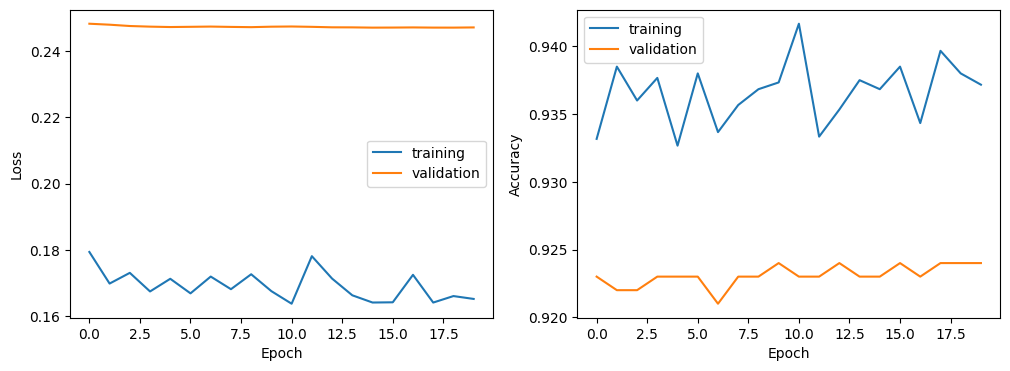

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
figs, axs=plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(train_hist.history['loss'], label='training')
axs[0].plot(train_hist.history['val_loss'], label='validation')
axs[0].legend()
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[1].plot(train_hist.history['accuracy'], label='training')
axs[1].plot(train_hist.history['val_accuracy'], label='validation')
axs[1].legend()
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
plt.show()

少ないデータ件数、少ない計算時間で、それなりの性能が出るまでに訓練できることを確認できました。